## 1. Reading in the data 

In [1]:
import numpy
from scipy.fftpack import dct
from scipy.io import wavfile
import pandas as pd
import numpy as np
from pylab import specgram
import os
from python_speech_features import mfcc
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks_cwt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import re
from script import *
%matplotlib inline

c:\anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data_dir='data/101/'
file_name = os.listdir(data_dir)
sampleRate = np.zeros(10)
signal= [0]*10
index=0
for wav in file_name :
    if len(re.findall('(.wav)',wav))>0:
        sampleRate[index], signal[index] = wavfile.read(data_dir+wav)
        index+=1


In [6]:
len(signal[0])

40320

In [3]:
# create figure window
def plot_signal_grid(signal,color):
    
    fig = plt.figure(figsize=(18,6)) 
    
    gs = gridspec.GridSpec(2, 5)
    # Creates grid 'gs' of a rows and b columns 

    for i,s in enumerate(signal):
        y=i
        x=i/5
        if i>4 : y= y-5
        #mpl.rcParams.update(mpl.rcParamsDefault)
        plt.style.use('bmh')

        ax = plt.subplot(gs[x, y])
        if color=='default':
            plt.plot(s)
        else:
            plt.plot(s,color=color)
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
        ax.set_title("Number : "+ str(i))
        
        fig.add_subplot(ax)
#mpl.rcParams.update(mpl.rcParamsDefault)        
     

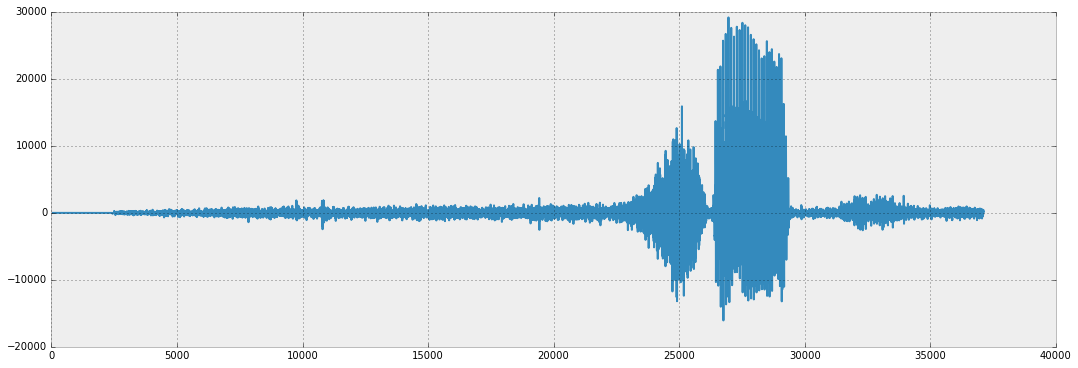

In [8]:
n=7
plt.figure(figsize=(18,6))
plt.style.use('bmh')
plt.plot(signal[n])

plt.show()

From the above plot we can see that the signals are not fully isolated and they accompanied by noise and silence.
A simple trimming based on magnitude and standard frequency based filtering will not be able to successfully isolate the signal because of the following reasons:
1. Conventional frequency based filtering is unable to remove noise generated from human vocal chords as these noise lie in the same frequency range as the signal
2. A simple magnitude based triming in the time domain will not be able to remove noise with large amplitudes
3. Some signals like 'Number: 0' are signals that are 2 syllables long and therefore have 2 peaks the smaller of which might not be captured 

### 2. Clipping and filtering the data

In [4]:
window=2000 
temp=np.array(signal[n])
remain = len(temp) %window
if ( remain==0):
    signal_temp=np.mean(abs(temp.reshape(-1,window)),1)
else:
    signal_temp=np.mean(abs(temp[0:-remain].reshape(-1,window)),1)

i=np.argmax(signal_temp)

temp=abs(signal_temp) - np.concatenate([np.zeros(1),abs(signal_temp[0:len(signal_temp)-1])])
temp_array=np.sort(np.unique(np.append(np.argmax(signal_temp),np.where(temp<300))))
temp_index =np.where(temp_array==i)[0]

lower_bound = (temp_array[temp_index-1]+1)*window
upper_bound = (temp_array[temp_index+1]+1)*window


NameError: name 'n' is not defined

To isolate the signal, the average amplitude of each window of 2000 frames is first calculated to smooth the noisy wav file.

The signal is assumed to reside in the window with the largest average amplitude.

The location of the largest window coupled with the change in gradient of the smoothed wav file on either sides of the largest window allows us to isolate the signal that we are interested in

36000


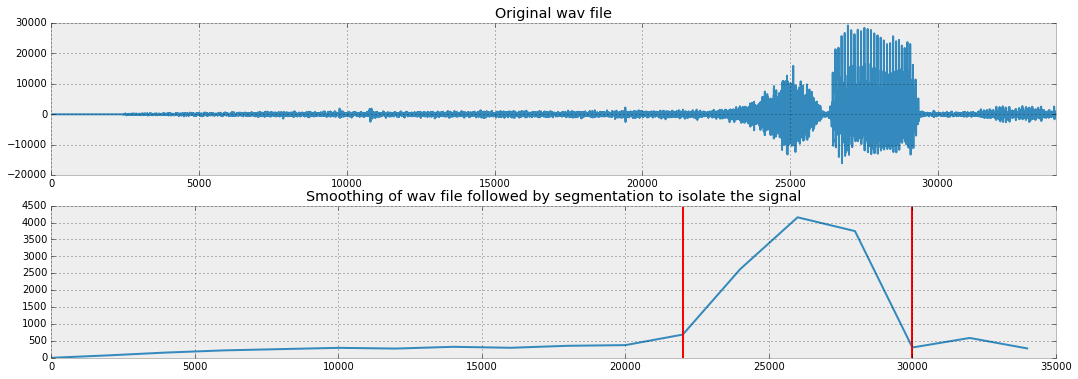

In [18]:
plt.figure(figsize=(18,6))
gs = gridspec.GridSpec(2, 2)
ax=plt.subplot(gs[0,:])
ax.set_title("Original wav file")
print len(signal_temp)*2000
plt.plot(signal[n][0:(len(signal_temp))*2000])

plt.xlim([0,(len(signal_temp)-1)*2000])
ax=plt.subplot(gs[1,:])
ax.set_title("Smoothing of wav file followed by segmentation to isolate the signal")

plt.plot(np.array(range(len(signal_temp)))*2000,signal_temp)
plt.axvline(x=lower_bound,color='red')
plt.axvline(x=upper_bound,color='red')

plt.show()


In [19]:
signal_filtered=[]

for i in signal:
    signal_filtered.append(time_amplitude_filter(i))


#### The 10 plots below show the original wav files

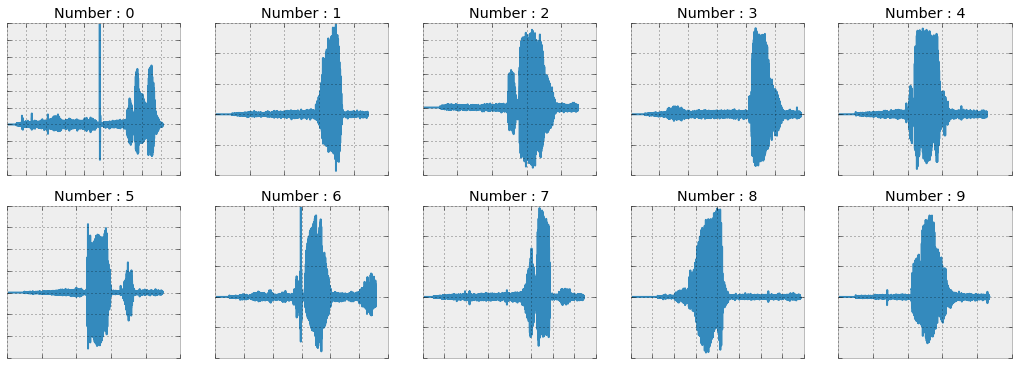

In [8]:
plot_signal_grid(signal,'default')   

#### The 10 plots below show the filtered wav files

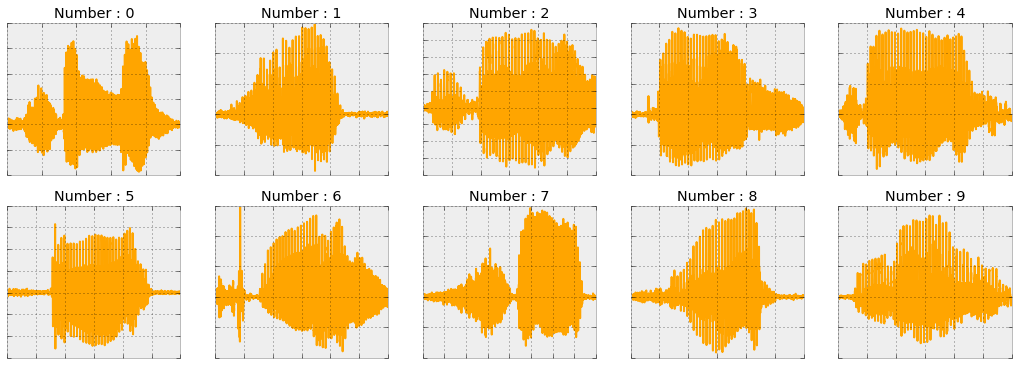

In [23]:
plot_signal_grid(signal_filtered,color='orange')

### 3. Extracting features from the data

In [20]:
wavfile.write('note_book_example.wav',sampleRate[n],signal_filtered[n])
sampleRate_example, signal_example = wavfile.read('note_book_example.wav')
features =signal_feature_generation(signal_example,sampleRate_example)

In [22]:
l=[]
l.append(features)
l.append(features+1)

AttributeError: 'list' object has no attribute 'tolist'

<b>The MFCC (using 13 coefficients) based features used here include</b>
1. The average MFCC coefficients across all frames
2. The maximum MFCC coefficients across all frames 
3. The minimum MFCC coefficients across all frames
4. The standard deviation of MFCC coefficients across all frames
5. The average rate of change of the MFCC coefficients across all frames

<b>Other features include</b>
1. The frequency of the wav file that produces the largest amplitude
2. The maximum amplitude
3. The length of the wav file
4. The amount of time taken to reach maximum aplitude

This produces 69 features for each wav file

In [13]:
print features
print features.shape

[  5.00000000e-01   3.61000000e+02   4.15430750e+03   5.00000000e-01
   2.30660738e+01   7.39804223e+00   1.26554435e+01   1.39689932e+01
   7.77669431e-01   1.61377980e+01   1.04471894e+01   4.79801995e+00
   2.76693204e+01   9.90686980e+00   1.46266966e+01   1.01441210e+01
   5.86475155e+00   1.50051261e+01  -5.40638549e+01  -3.36703998e+01
  -3.08842227e+01  -3.41167749e+01  -2.10061183e+01  -2.32562359e+01
  -1.68021750e+01  -1.28355942e+01  -2.43417274e+01  -1.27305309e+01
  -4.15168732e+01  -1.46910885e+01   2.02347993e+01  -2.08875761e+01
  -8.00702730e+00  -4.98185479e+00  -1.83077867e+01  -5.61467266e+00
  -6.01570813e+00  -4.80425611e+00   4.62736643e+00  -7.01849304e+00
   4.00324737e+00  -1.79750253e+01  -2.72000043e+00   2.07504106e+00
   1.98059014e+01   1.45429240e+01   1.37523928e+01   8.66742901e+00
   1.05154160e+01   8.06538381e+00   5.20296700e+00   1.23588236e+01
   8.16389310e+00   7.07917115e+00   1.49783957e+01   4.38141865e+00
   3.12103319e-01  -2.95652060e-01

### 4. Modeling

To run the code to generate the model the user has to specify the main directory of the data as well as the folder the data resides in. In addition, the output folder has to be specified.

In [17]:
#rootdir='c:/users/firmansv/bengali/'
rootdir = 'C:/Users/hungdin/Documents/bengali/'
fol_input= 'data'
fol_output ='data_filt4'

The <b>scan_wav( )</b> function reads in all the files present in the specificed input folder and isolates the signal absed on the method extracted above. The extracted signal is then saved as a new file in the specified output folder
- This function reads in the filtered wav files from the specified root directory and output folder and applies the signal_feature_generation() function to extract features from each signal.
- The function reads in n signals and outputs a nx69 dataframe containing the features corresponding to each signal
as well as a numpy array of length n containing the labels extracted from the filenames
- <b>Note</b>: The 16xx series sub-folders are excluded from this analysis due to their quality.

In [ ]:
scan_wav(rootdir,fol_input,fol_output)

The <b>extract_features( )</b> function generates a dataframe containing features for each file as well as a numpy array containing the label extracted from the filename
- This function reads in the filtered wav files from the specified root directory and output folder and applies the signal_feature_generation() function to extract features from each signal.
- The function reads in n signals and outputs a nx69 dataframe containing the features corresponding to each signal as well as a numpy array of length n containing the labels extracted from the filenames
- Usage: extract_features(rootdir,fol_output='output')

In [18]:
data,y=extract_features(rootdir,fol_output)  

The <b>sklearn_model( )</b> function takes in 3 inputs, a sklearn model, the features generated from the data as well as the labels of the data.
- This function takes in a specified sklearn model , the number of folds, the features that characterize the signals and the labels of the signals and applies the model through stratified k fold cross validation
- The outputs of the function include the 4 fold cross validation scores (accuracy) as well as the average score across 4 folds

In [24]:
model_log=RandomForestClassifier(  n_estimators=300, random_state=0)

In [25]:
score,results=sklearn_model(model_log,4,data,y)

In [26]:
score, results

(0.83527256956735996,
 array([ 0.76143293,  0.76346962,  0.83454337,  0.98164436]))

In [13]:
data.shape

(11111, 69)

#### Using 11111 wav files to train the randomForest classifier, we are able to acehive 83.5% accuracy in classifying the wav files 